In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import surprise

from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, BaselineOnly, NormalPredictor
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate, split
from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict

In [2]:
metadata_df  = pd.read_csv('data/movies_metadata.csv')
credits_df   = pd.read_csv('data/credits.csv')
keywords_df  = pd.read_csv('data/keywords.csv')
links_df     = pd.read_csv('data/links.csv')
ratings_df   = pd.read_csv('data/ratings.csv')


C:\Users\lcd54\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Returns the list of names
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]

        return names

    #Return empty list in case of missing/malformed data
    return []

In [4]:
# Returns the list of names
def get_actor_5(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        
        #Check if more than 3 elements exist. If yes, return only first five. If no, return entire list.
        if len(names) >5:
            names = names[:5]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [5]:
print(metadata_df['id'].shape, credits_df.shape,keywords_df.shape)

(45466,) (45476, 3) (46419, 2)


In [6]:
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [7]:
keywords = keywords_df['keywords'].apply(literal_eval)
keywords = keywords.apply(get_list)
keywords_df['keywords'] = keywords
keywords_df.head()

,id,keywords
0,862,"[jealousy, toy, boy, friendship, friends, riva..."
1,8844,"[board game, disappearance, based on children'..."
2,15602,"[fishing, best friend, duringcreditsstinger, o..."
3,31357,"[based on novel, interracial relationship, sin..."
4,11862,"[baby, midlife crisis, confidence, aging, daug..."


In [8]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [9]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [10]:
pd.set_option('display.max_columns', None)
metadata_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [11]:
genres_df = metadata_df['genres'].apply(literal_eval)
genres_df = genres_df.apply(get_list)
metadata_df['genres'] = genres_df.apply(sorted)


In [12]:
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [13]:
cast_df = credits_df['cast'].apply(literal_eval)
cast_df = cast_df.apply(get_actor_5)

In [14]:
credits_df['cast']=cast_df
credits_df

,cast,crew,id
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862
...,...,...,...
45471,"[Leila Hatami, Kourosh Tahami, Elham Korda]","[{'credit_id': '5894a97d925141426c00818c', 'de...",439050
45472,"[Angel Aquino, Perry Dizon, Hazel Orencio, Joe...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de...",111109
45473,"[Erika Eleniak, Adam Baldwin, Julie du Page, J...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de...",67758
45474,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...","[{'credit_id': '533bccebc3a36844cf0011a7', 'de...",227506


In [15]:
prodcntry_df = metadata_df['production_countries'].fillna('[]')
prodcntry_df = prodcntry_df.apply(literal_eval)
prodcntry_df = prodcntry_df.apply(get_list)

In [16]:
metadata_df['production_countries'] = prodcntry_df

###  Break

In [17]:
metadata_sub1 = metadata_df[['id','title','genres','overview','tagline','budget','popularity','runtime','vote_average','vote_count','production_countries']]
metadata_sub1 = metadata_sub1.drop([19730,29503,35587])


In [18]:
metadata_sub1['id']=metadata_sub1['id'].astype(int)

In [19]:
pd.set_option('display.max_rows', 20)
df_1 = pd.merge(credits_df, keywords_df, on='id',how='left')
df_1
df_2 = df_1.merge(metadata_sub1, on='id')
df_2.head(5)

,cast,crew,id,keywords,title,genres,overview,tagline,budget,popularity,runtime,vote_average,vote_count,production_countries
0,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862,"[jealousy, toy, boy, friendship, friends, riva...",Toy Story,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",NaN,30000000,21.9469,81.0,7.7,5415.0,[United States of America]
1,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844,"[board game, disappearance, based on children'...",Jumanji,"[Adventure, Family, Fantasy]",When siblings Judy and Peter discover an encha...,Roll the dice and unleash the excitement!,65000000,17.0155,104.0,6.9,2413.0,[United States of America]
2,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602,"[fishing, best friend, duringcreditsstinger, o...",Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,Still Yelling. Still Fighting. Still Ready for...,0,11.7129,101.0,6.5,92.0,[United States of America]
3,"[Whitney Houston, Angela Bassett, Loretta Devi...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357,"[based on novel, interracial relationship, sin...",Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",Friends are the people who let you be yourself...,16000000,3.85949,127.0,6.1,34.0,[United States of America]
4,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862,"[baby, midlife crisis, confidence, aging, daug...",Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,Just When His World Is Back To Normal... He's ...,0,8.38752,106.0,5.7,173.0,[United States of America]


In [20]:
links_df

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
45838,176269,6209470,439050.0
45839,176271,2028550,111109.0
45840,176273,303758,67758.0
45841,176275,8536,227506.0


In [21]:
tmdb_df = links_df[links_df['tmdbId'].notnull()]['tmdbId'].astype('int')
df_2['id'] = df_2['id'].astype('int')
df_2 = df_2[df_2['id'].isin(tmdb_df)]

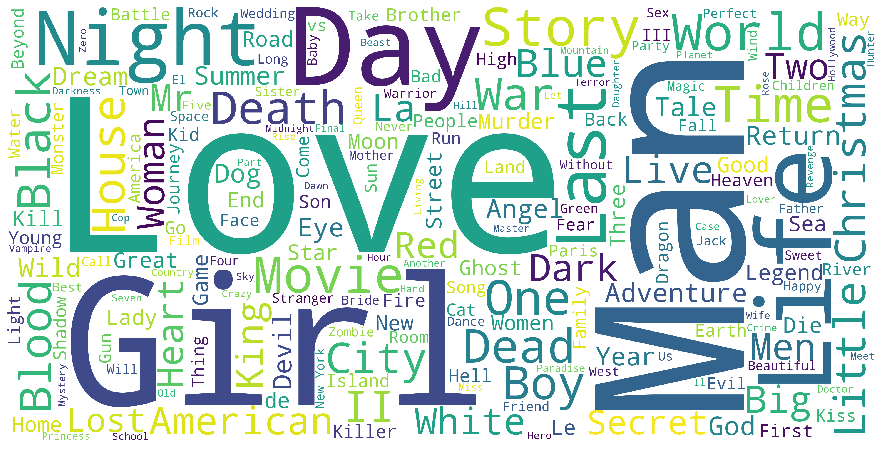

In [22]:
test = df_2['title'].astype('str')
title_corpus = ' '.join(test)

title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

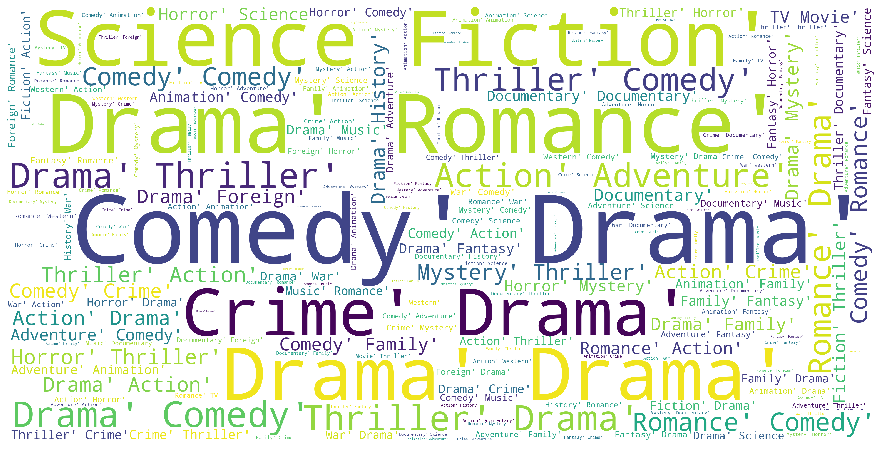

In [23]:
test = df_2['genres'].astype('str')
genre_corpus = ' '.join(test)

genre_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(genre_corpus)
plt.figure(figsize=(16,8))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

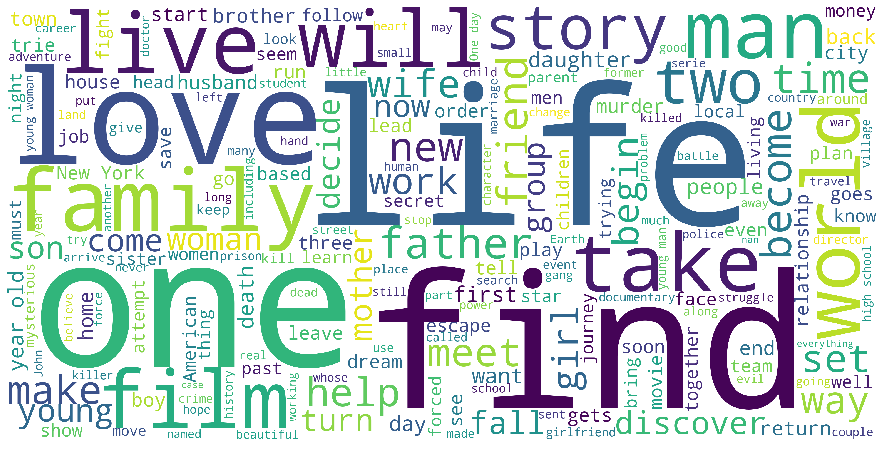

In [24]:
test = df_2['overview'].astype('str')

overview_corpus = ' '.join(test)

overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

In [25]:
pd.options.display.max_rows = 100

genres_df_sorted = genres_df.apply(sorted)
pd.DataFrame(genres_df_sorted.value_counts()).head(15)


,genres
[Drama],5000
[Comedy],3621
[Documentary],2723
[],2442
"[Comedy, Drama]",1667
"[Drama, Romance]",1644
"[Comedy, Romance]",1143
"[Comedy, Drama, Romance]",1031
[Horror],974
"[Horror, Thriller]",680


In [26]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [27]:
ratings_df_2 = pd.merge(ratings_df, links_df[['movieId','tmdbId']], left_on = 'movieId', right_on= 'movieId', how='left')
ratings_df_2.dropna(inplace= True)
ratings_df_2 = ratings_df_2[['userId','tmdbId','rating']]
ratings_df_2.columns = ['userId','id','rating']

joined_df = pd.merge(ratings_df_2, df_2[['id','title','genres']], left_on = 'id', right_on = 'id', how = 'left')

In [28]:
joined_df['genres'] = joined_df['genres'].astype('str')
joined_df.head()

,userId,id,rating,title,genres
0,1,197.0,1.0,Braveheart,"['Action', 'Drama', 'History', 'War']"
1,1,10474.0,4.5,The Basketball Diaries,"['Crime', 'Drama']"
2,1,238.0,5.0,The Godfather,"['Crime', 'Drama']"
3,1,240.0,5.0,The Godfather: Part II,"['Crime', 'Drama']"
4,1,207.0,5.0,Dead Poets Society,['Drama']


In [29]:
pd.pivot_table(joined_df, values='rating',index=['userId', 'genres'], aggfunc=('mean')).head(15)

rating
userId genres                                               
1      ['Action', 'Adventure', 'Crime', 'Mystery']  5.000000
       ['Action', 'Adventure', 'Fantasy']           0.500000
       ['Action', 'Adventure', 'Science Fiction']   5.000000
       ['Action', 'Crime', 'Drama', 'Thriller']     4.000000
       ['Action', 'Crime', 'Drama']                 4.000000
       ['Action', 'Drama', 'History', 'War']        1.000000
       ['Adventure', 'Family', 'Fantasy']           5.000000
       ['Adventure', 'Fantasy', 'Science Fiction']  2.500000
       ['Comedy', 'Drama']                          4.500000
       ['Comedy']                                   4.250000
       ['Crime', 'Drama']                           4.833333
       ['Drama', 'Fantasy', 'Mystery']              5.000000
       ['Drama', 'Mystery', 'Thriller']             4.500000
       ['Drama', 'Romance']                         5.000000
       ['Drama', 'Western']                         4.000000

In [30]:
genres_rating_cnt = pd.pivot_table(joined_df, values='rating',index=[ 'genres'], aggfunc=('count'))

In [31]:
genres_rating_cnt.sort_values(by='rating',ascending=False).head(15)

,rating
genres,
['Drama'],1526990
['Comedy'],1244478
"['Comedy', 'Drama', 'Romance']",1059254
"['Comedy', 'Drama']",804489
"['Comedy', 'Romance']",759865
"['Drama', 'Romance']",719132
"['Action', 'Adventure', 'Science Fiction']",687165
"['Crime', 'Drama', 'Thriller']",670270
"['Crime', 'Drama']",660068


In [32]:
category = joined_df.loc[1,'genres']


bool_indx = joined_df['genres'] == category

joined_df.loc[bool_indx]
k = pd.pivot_table(joined_df.loc[bool_indx], values='rating',index=['userId'], aggfunc=('mean'))



In [33]:
category

"['Crime', 'Drama']"

(array([0.01025899, 0.01667968, 0.01028722, 0.03430483, 0.03527852,
        0.17261074, 0.2304393 , 0.61357814, 0.51747945, 0.58130535]),
 array([0.5 , 0.95, 1.4 , 1.85, 2.3 , 2.75, 3.2 , 3.65, 4.1 , 4.55, 5.  ]),
 <a list of 10 Patch objects>)

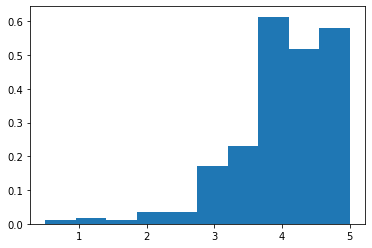

In [34]:
plt.hist(k['rating'], bins= 10, density= True)

### Content Based Filtering - Taglines and Overview and applying TF-IDF Vectorizor

In [35]:
metadata_df_sub = df_2.iloc[0:15000,]
overview_df = metadata_df_sub['overview'].fillna('')
tagline_df = metadata_df_sub['tagline'].fillna('')

description_df = overview_df + tagline_df

In [36]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(description_df)
tfidf_matrix.shape

(15000, 419681)

In [37]:
#finding cosine similiarity with linear_kernal
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim

array([[1.        , 0.00612624, 0.        , ..., 0.        , 0.        ,
        0.00695305],
       [0.00612624, 1.        , 0.01482048, ..., 0.00268799, 0.        ,
        0.        ],
       [0.        , 0.01482048, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.00268799, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.00738908],
       [0.00695305, 0.        , 0.        , ..., 0.        , 0.00738908,
        1.        ]])

In [38]:
titles = metadata_df_sub['title']
indices = pd.Series(metadata_df_sub.index, index=metadata_df_sub['title'])

In [39]:
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = indices[title]
    
    if isinstance(idx,pd.Series):
        idx = idx[0]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [40]:
j = get_recommendations('Toy Story').head(10).index

metadata_df_sub.loc[j,['title','tagline','overview']]

,title,tagline,overview
3024,Toy Story 2,The toys are back!,"Andy heads off to Cowboy Camp, leaving his toy..."
10389,The 40 Year Old Virgin,"The longer you wait, the harder it gets",Andy Stitzer has a pleasant life with a nice a...
8410,The Champ,NaN,"Dink Purcell loves his alcoholic father, ex-he..."
3084,Man on the Moon,"Hello, my name is Andy and this is my movie.",A film about the life and career of the eccent...
11715,Factory Girl,"When Andy met Edie, life imitated art.","In the mid-1960s, wealthy debutant Edie Sedgwi..."
6504,"What's Up, Tiger Lily?",WOODY ALLEN STRIKES BACK!,"In comic Woody Allen's film debut, he took the..."
1092,Rebel Without a Cause,The bad boy from a good family.,"After moving to a new town, troublemaking teen..."
11508,For Your Consideration,NaN,Three actors learn that their respective perfo...
5859,Class of 1984,Class of 1984. Is this the future?,Andy is a new teacher at a inner city high sch...
1952,Condorman,An action adventure romantic comedy spy story.,Comic artist and writer Woody performs a simpl...


In [41]:
for i in titles.iloc[0:10,]:
    j = get_recommendations(i).head(5).index
    print(i,'\n',metadata_df_sub.loc[j,'title'],'\n')


Toy Story 
 3024                Toy Story 2
10389    The 40 Year Old Virgin
8410                  The Champ
3084            Man on the Moon
11715              Factory Girl
Name: title, dtype: object 

Jumanji 
 9584               Word Wars
8884                 Quintet
9837           The Phone Box
14848    The Spousals of God
13862             Rhinoceros
Name: title, dtype: object 

Grumpier Old Men 
 9289     An Extremely Goofy Movie
3357               Grumpy Old Men
9199             Wishful Thinking
11364               Pretty Poison
443                      Fearless
Name: title, dtype: object 

Waiting to Exhale 
 8236                Mask
2161                Hero
411            Bad Girls
9876    God Is Brazilian
6944           Silverado
Name: title, dtype: object 

Father of the Bride Part II 
 6862     Father of the Bride
6640                   Kuffs
6375         North to Alaska
13762    The Magic of Méliès
5046                 Wendigo
Name: title, dtype: object 

Heat 
 700         

### Credits, Genres and Keywords Based Recommender

In [42]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''
        
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])


In [43]:
df_2['crew'] = df_2['crew'].apply(literal_eval)

In [44]:
df_2['director'] = df_2['crew'].apply(get_director)


In [45]:
df_2['crew'] = df_2['crew'].apply(get_list)

In [46]:
df_2['crew']

0        [John Lasseter, Joss Whedon, Andrew Stanton, J...
1        [Larry J. Franco, Jonathan Hensleigh, James Ho...
2        [Howard Deutch, Mark Steven Johnson, Mark Stev...
3        [Forest Whitaker, Ronald Bass, Ronald Bass, Ez...
4        [Alan Silvestri, Elliot Davis, Nancy Meyers, N...
                               ...                        
46623    [Hamid Nematollah, Hamid Nematollah, Farshad M...
46624    [Lav Diaz, Lav Diaz, Dante Perez, Lav Diaz, La...
46625    [Mark L. Lester, C. Courtney Joyner, Jeffrey G...
46626              [Yakov Protazanov, Joseph N. Ermolieff]
46627                                      [Daisy Asquith]
Name: crew, Length: 46628, dtype: object

In [47]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df_2[feature] = df_2[feature].apply(clean_data)

In [48]:
df_2['soup'] = df_2.apply(create_soup, axis=1)

In [49]:
#make a subset and reassign variable in the Recommendation function
df_2_sub = df_2.loc[0:15000,:]

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df_2_sub['soup'])

In [50]:
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [51]:
# Reset index of our main DataFrame and construct reverse mapping as before
df_2_sub = df_2_sub.reset_index()
indices = pd.Series(df_2_sub.index, index=df_2_sub['title'])
titles = df_2_sub['title']

In [86]:
get_recommendations('The Godfather', cosine_sim=cosine_sim2)

1199             The Godfather: Part II
1934            The Godfather: Part III
10261                        The Outfit
11733          The Consequences of Love
5309                        The Gambler
3327             ...And Justice for All
4602                    The Cotton Club
9517                     The Black Lapp
1614                      The Rainmaker
12221                       10th & Wolf
1648                   Ill Gotten Gains
3487         Jails, Hospitals & Hip-Hop
6744                               Ruby
7772                           Mitchell
8001     The Night of the Following Day
5793                   True Confessions
1430                      Donnie Brasco
549                       Trial by Jury
2112                  The Paradine Case
10729                House of Strangers
13361               Manhattan Melodrama
276                 Murder in the First
9874                    Amongst Friends
1186                     Apocalypse Now
3640                            Serpico


In [81]:
for i in get_recommendations('The Godfather', cosine_sim=cosine_sim2).index:
    print(i,algo.predict(1,i))

1199 user: 1          item: 1199       r_ui = None   est = 4.07   {'was_impossible': False}
1934 user: 1          item: 1934       r_ui = None   est = 4.76   {'was_impossible': False}
10261 user: 1          item: 10261      r_ui = None   est = 4.08   {'was_impossible': False}
11733 user: 1          item: 11733      r_ui = None   est = 4.07   {'was_impossible': False}
5309 user: 1          item: 5309       r_ui = None   est = 4.07   {'was_impossible': False}
3327 user: 1          item: 3327       r_ui = None   est = 4.07   {'was_impossible': False}
4602 user: 1          item: 4602       r_ui = None   est = 4.07   {'was_impossible': False}
9517 user: 1          item: 9517       r_ui = None   est = 4.37   {'was_impossible': False}
1614 user: 1          item: 1614       r_ui = None   est = 4.07   {'was_impossible': False}
12221 user: 1          item: 12221      r_ui = None   est = 4.07   {'was_impossible': False}
1648 user: 1          item: 1648       r_ui = None   est = 3.89   {'was_impos

In [54]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [55]:
links_df.loc[links_df["tmdbId"]==240,:]

,movieId,imdbId,tmdbId
1195,1221,71562,240.0


### Collaborative Filtering

In [56]:
reader = Reader()

In [57]:
ratings_df_sub = joined_df.iloc[0:500000,]
ratings_df_sub.head(26)

,userId,id,rating,title,genres
0,1,197.0,1.0,Braveheart,"['Action', 'Drama', 'History', 'War']"
1,1,10474.0,4.5,The Basketball Diaries,"['Crime', 'Drama']"
2,1,238.0,5.0,The Godfather,"['Crime', 'Drama']"
3,1,240.0,5.0,The Godfather: Part II,"['Crime', 'Drama']"
4,1,207.0,5.0,Dead Poets Society,['Drama']
5,1,2108.0,4.0,The Breakfast Club,"['Comedy', 'Drama']"
6,1,745.0,4.5,The Sixth Sense,"['Drama', 'Mystery', 'Thriller']"
7,1,9377.0,5.0,Ferris Bueller's Day Off,['Comedy']
8,1,550.0,4.0,Fight Club,['Drama']
9,1,77.0,4.0,Memento,"['Mystery', 'Thriller']"


In [58]:
data = Dataset.load_from_df(ratings_df_sub[['userId', 'id', 'rating']], reader)
trainset = data.build_full_trainset()

In [59]:
cross_validate(SVD(), data, cv=5)

{'test_rmse': array([0.84197409, 0.84250335, 0.84057387, 0.84563949, 0.84260767]),
 'test_mae': array([0.64127042, 0.64172281, 0.64142046, 0.64396411, 0.64277772]),
 'fit_time': (44.65542125701904,
  39.38945007324219,
  38.58186101913452,
  38.70787477493286,
  39.0138795375824),
 'test_time': (3.14481782913208,
  1.3251121044158936,
  1.9371294975280762,
  1.7961459159851074,
  1.3011114597320557)}

In [60]:
# We'll use the famous SVD algorithm.
algo = SVD()
algo_base = BaselineOnly()
algo_norm = NormalPredictor()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
algo_base.fit(trainset)
algo_norm.fit(trainset)

Estimating biases using als...


In [111]:
algo.predict(1, 240)

Prediction(uid=1, iid=240, r_ui=None, est=4.709245572195458, details={'was_impossible': False})

In [62]:
algo_base.predict(1, 240)

Prediction(uid=1, iid=240, r_ui=None, est=4.522810074111899, details={'was_impossible': False})

In [63]:
algo_norm.predict(1, 240)

Prediction(uid=1, iid=240, r_ui=None, est=2.909404428315421, details={'was_impossible': False})

In [64]:
test = joined_df["title"]=="The Godfather"

len(joined_df.loc[test,:])

57070

In [65]:
np.mean(joined_df.loc[test,"rating"])

4.339810758717364

### Hyrbrid Recommender

In [66]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [67]:
id_map = links_df.loc[:,['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(df_2[['title', 'id']], on='id').set_index('title')

In [115]:
id_map.loc[id_map['id']==240,:]

,movieId,id
title,,
The Godfather: Part II,1221,240.0


In [116]:
indices_map = id_map.set_index('id')

In [117]:
id_map.head()

,movieId,id
title,,
Toy Story,1,862.0
Jumanji,2,8844.0
Grumpier Old Men,3,15602.0
Waiting to Exhale,4,31357.0
Father of the Bride Part II,5,11862.0


In [70]:
ratings_df_sub = joined_df.iloc[0:500000,]
np.unique(ratings_df_sub['id'])

array([2.00000e+00, 5.00000e+00, 6.00000e+00, ..., 4.58808e+05,
       4.59295e+05, 4.61297e+05])

In [129]:
def hybrid(userId, title, cosine_sim = cosine_sim):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    #print(idx)
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:36]
    #print(sim_scores)
    movie_indices = [i[0] for i in sim_scores]
    
    movies = metadata_df_sub.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'id']]
    movies['est'] = movies['id'].apply(lambda x: algo.predict(userId, x).est)
    movies = movies.sort_values(by = ['est','vote_count'], ascending=False)
    return movies.head(10)

In [93]:
indices["The Godfather: Part II"]

1934

In [103]:
sim_scores_test = sorted(list(enumerate(cosine_sim2[841])), key=lambda x: x[1], reverse=True)
sim_scores_test = sim_scores_test[1:36]
movie_indices_test = [i[0] for i in sim_scores_test]

In [120]:
movies_test = metadata_df_sub.iloc[movie_indices_test][['title', 'vote_count', 'vote_average', 'id']]
movies_test['est'] = movies_test['id'].apply(lambda x: algo.predict(1, x).est)

In [121]:
movies_test

,title,vote_count,vote_average,id,est
1199,The Godfather: Part II,3418.0,8.3,240,4.709246
1934,The Godfather: Part III,1589.0,7.1,242,4.260761
10261,The Outfit,12.0,6.0,26762,4.069370
11733,The Consequences of Love,125.0,7.6,24653,4.353019
5309,The Gambler,21.0,7.0,44800,4.069370
3327,...And Justice for All,118.0,7.1,17443,4.200554
4602,The Cotton Club,71.0,6.5,2148,3.976081
9517,The Black Lapp,6.0,5.5,14190,4.069370
1614,The Rainmaker,239.0,6.7,11975,4.212577
12221,10th & Wolf,26.0,6.3,13197,4.027347


In [112]:
indices_map.loc[240]['movieId']

1221

In [113]:
indices_map

,movieId
id,
862.0,1
8844.0,2
15602.0,3
31357.0,4
11862.0,5
...,...
439050.0,176269
111109.0,176271
67758.0,176273


In [105]:
movies_test

,title,vote_count,vote_average,id,est
1199,The Godfather: Part II,3418.0,8.3,240,4.069370
1934,The Godfather: Part III,1589.0,7.1,242,3.923430
10261,The Outfit,12.0,6.0,26762,4.069370
11733,The Consequences of Love,125.0,7.6,24653,4.069370
5309,The Gambler,21.0,7.0,44800,4.069370
3327,...And Justice for All,118.0,7.1,17443,4.069370
4602,The Cotton Club,71.0,6.5,2148,4.069370
9517,The Black Lapp,6.0,5.5,14190,4.069370
1614,The Rainmaker,239.0,6.7,11975,4.557446
12221,10th & Wolf,26.0,6.3,13197,4.069370


In [130]:
hybrid(1,"The Godfather",cosine_sim2)

,title,vote_count,vote_average,id,est
1186,Apocalypse Now,2112.0,8.0,28,4.896881
1199,The Godfather: Part II,3418.0,8.3,240,4.709246
3640,Serpico,429.0,7.5,9040,4.594673
7052,Shoot the Piano Player,69.0,7.2,1818,4.514795
11733,The Consequences of Love,125.0,7.6,24653,4.353019
4080,Pixote,24.0,8.4,42148,4.273290
1934,The Godfather: Part III,1589.0,7.1,242,4.260761
5793,True Confessions,31.0,5.6,32077,4.247444
1614,The Rainmaker,239.0,6.7,11975,4.212577
13361,Manhattan Melodrama,19.0,6.3,28564,4.203361


In [90]:
algo.predict(1,11975)

Prediction(uid=1, iid=11975, r_ui=None, est=4.212576794748775, details={'was_impossible': False})

### Precision At K

In [75]:


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [76]:
kf = KFold(n_splits=5)

In [77]:
for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=15, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.686946018207641
0.5823154006263952
0.6786024412038126
0.5827556585623226
0.6819901637571971
0.5783842385713234
0.6846353874720447
0.5845807555776447
0.6815726969038143
0.5827358185004724


In [78]:
for trainset, testset in kf.split(data):
    algo_base.fit(trainset)
    predictions = algo_base.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=15, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

Estimating biases using als...
0.6819461550507154
0.5922675988642132
Estimating biases using als...
0.682239966192877
0.5943782529493276
Estimating biases using als...
0.686557551384705
0.5949571997956546
Estimating biases using als...
0.6835979373323741
0.5881953343574056
Estimating biases using als...
0.6852696646976124
0.5919756299307045


In [79]:
for trainset, testset in kf.split(data):
    algo_norm.fit(trainset)
    predictions = algo_norm.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=15, threshold=3.5)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

0.5870113653329337
0.4300452818309432
0.5733215599292586
0.4278780969811183
0.5834575781444241
0.4323312422689851
0.5880996064232025
0.4389324105710482
0.5772951846028765
0.43048825779599303


In [80]:
help(surprise)

Help on package surprise:

NAME
    surprise

PACKAGE CONTENTS
    __main__
    accuracy
    builtin_datasets
    dataset
    dump
    model_selection (package)
    prediction_algorithms (package)
    reader
    similarities
    trainset
    utils

CLASSES
    builtins.Exception(builtins.BaseException)
        surprise.prediction_algorithms.predictions.PredictionImpossible
    builtins.object
        surprise.dataset.Dataset
        surprise.prediction_algorithms.algo_base.AlgoBase
            surprise.prediction_algorithms.baseline_only.BaselineOnly
            surprise.prediction_algorithms.co_clustering.CoClustering
            surprise.prediction_algorithms.matrix_factorization.NMF
            surprise.prediction_algorithms.matrix_factorization.SVD
            surprise.prediction_algorithms.matrix_factorization.SVDpp
            surprise.prediction_algorithms.random_pred.NormalPredictor
            surprise.prediction_algorithms.slope_one.SlopeOne
        surprise.reader.Reader
   